In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
data=pd.read_excel('/content/fall_processed_norm.xlsx')
data.columns

Index(['Application Reference ID', 'Application Major', 'Scholarship_Awarded',
       'Application CGPA', 'FAFSA Filed', 'High School Code',
       'Financial Aid Appeal', 'Accepted Student Day Event Attended',
       'Campus Visits - Person', 'Campus Visits - App', 'Logins Before Admit',
       'Acceptance Call Success', 'Application Consider Test Scores',
       'Application ACRK', 'Waitlist Confirmed Date', 'Emails Sent',
       'Emails Opened', 'Was Inquiry', 'Athlete', 'admitted',
       'Application College_00', 'Application College_CAS',
       'Application College_COB', 'Application College_HCLC',
       'Application College_ID', 'Application College_SHS',
       'Application College_TCOE', 'Application Housing_Commuter',
       'Application Housing_Residential', 'Application Housing_nan',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Application Span',
       'Admission Span', 'Person Sex_F', 'Person Sex_M', 'Person Sex_Unknown',


In [ ]:
inputs=data.drop(['Application Reference ID','admitted'],axis=1).to_numpy()
labels=data['admitted'].to_numpy()
app_id=data['Application Reference ID']
inputs=torch.from_numpy(inputs).float()
unique_majors = int(inputs[:, 0].max()) + 1  # 112
unique_highschools = int(inputs[:, 4].max()) + 1
print(inputs.shape[1],unique_majors,unique_highschools)
#make sure to convert the type to long as tensors deal with the long integer which are 64 bit not the 32 bit
labels=torch.from_numpy(labels).long()
#creates a dataset tensor for each label example can be seen below how it works
dataset=TensorDataset(inputs,labels)
#convert the train_size to integer as operation results in float
train_size=int((0.8*(len(dataset))))
test_size=len(dataset)-train_size
#print(train_size,test_size)
#split the data randomly and specify the length by using the array of training and testing size
train_dataset,test_dataset=random_split(dataset,[train_size-1,test_size+1])
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=True)


49 112 4002


In [ ]:

# import torch
# from torch.utils.data import TensorDataset, DataLoader

# # Creating sample data
# inputs = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])  # Features
# labels = torch.tensor([0, 1, 0])  # Target labels

# # Creating TensorDataset
# dataset = TensorDataset(inputs, labels)

# # Accessing data
# print(dataset[0])  # Output: (tensor([1., 2.]), tensor(0))

# # Creating a DataLoader for batch processing
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# # Iterating over DataLoader
# for batch in dataloader:
#     x, y = batch
#     print("Batch X:", x)
#     print("Batch Y:", y)


**kwargs(keyword arguments)<br>
class ConvexNet(torch.nn.Module):<br>
    def __init__(self, **kwargs):<br>
net = ConvexNet(size=[133, 512, 16, 2], use_dout=[True, 0.3])<br>
Behind the scenes, kwargs is:<br>
{
    "size": [133, 512, 16, 2],\
    "use_dout": [True, 0.3]\
}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

class ConvexNet(nn.Module):
    def __init__(self, **kwargs):
        super(ConvexNet, self).__init__()
        torch.manual_seed(2)

        self.embedding_dim = 300
        unique_majors, unique_highschools = kwargs["unique_majors"], kwargs["unique_highschools"]


        layer_sizes = kwargs["size"] # [n_input, n_hidden_1, n_hidden_2, n_output]
        # inputs = layer_sizes[0]
        # print(layer_sizes[0])
        layer_sizes[0]=(inputs- 2 + 2*self.embedding_dim)
        # print(layer_sizes[0])
        # Embedding layers for the categorical variables
        self.major_embedding = nn.Embedding(unique_majors, self.embedding_dim)
        self.hs_embedding = nn.Embedding(unique_highschools, self.embedding_dim)


        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]))
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i + 1], layer_sizes[i]))
                                   for i in range(1, len(layer_sizes) - 1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1])) for i in range(len(layer_sizes)-1)])

        self.act = F.relu
        self.use_dout = kwargs["use_dout"][0]
        self.dropout = nn.Dropout(p=kwargs["use_dout"][1])

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights using kaiming initialization
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5 ** 0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5 ** 0.5)
        for i, b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in ** 0.5)
            nn.init.uniform_(b, -bound, bound)
    def forward(self, x):
        # Separate the categorical and continuous inputs
        categorical_input_1 = x[:, 0].long()  # Application Major
        categorical_input_2 = x[:, 4].long()  # High school input (another categorical feature)

        continuous_indices = [i for i in range(x.shape[1]) if i not in [0, 4]]
        continuous_input = x[:, continuous_indices].float()  # The rest: continuous features

        # Apply embedding layers for categorical inputs
        major_embeddings = self.major_embedding(categorical_input_1)
        #print(major_embeddings.shape)
        hs_embeddings = self.hs_embedding(categorical_input_2)
        #print(hs_embeddings.shape)
        # Concatenate embeddings with continuous inputs
        x = torch.cat((major_embeddings, hs_embeddings, continuous_input), dim=1)
        #print(x.shape)

        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)
        if self.use_dout:
            z = self.dropout(z)

        for W, b, U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)
            if self.use_dout:
                z = self.dropout(z)

        out = F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]

        return out

unique_majors=int(inputs[:, 0].max()) + 1  # 112
unique_highschools = int(inputs[:, 4].max()) + 1 #4002


inputs=inputs.shape[1]
layer_sizes = [inputs, 512, 16, 2]  # [input_size, hidden_1, hidden_2, output_size]
use_dout = (True, 0.5)  # Use dropout with a probability of 0.5

# Initialize the model
net = ConvexNet(size=layer_sizes, unique_majors=unique_majors, unique_highschools=unique_highschools, use_dout=use_dout)

# Print the model architecture (optional)
print(net)

ConvexNet(
  (major_embedding): Embedding(112, 300)
  (hs_embedding): Embedding(4002, 300)
  (W): ParameterList(
      (0): Parameter containing: [torch.float32 of size 512x647]
      (1): Parameter containing: [torch.float32 of size 16x647]
      (2): Parameter containing: [torch.float32 of size 2x647]
  )
  (U): ParameterList(
      (0): Parameter containing: [torch.float32 of size 16x512]
      (1): Parameter containing: [torch.float32 of size 2x16]
  )
  (bias): ParameterList(
      (0): Parameter containing: [torch.float32 of size 512]
      (1): Parameter containing: [torch.float32 of size 16]
      (2): Parameter containing: [torch.float32 of size 2]
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
n_epochs = 500
learning_rate = 0.001
decay_rate = learning_rate / n_epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)

lambda_reg = 0.001
lambda_entropy = 0
def loss_fn(model, outputs, targets):
    cross_entropy = nn.functional.cross_entropy(outputs, targets)
    l2_regularization = 0
    entropy_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2
        entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))
    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

def test_instance(model):
    y_t = []
    y_s = []
    loss = 0
    acc = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    acc = accuracy_score(y_t, y_s)
    return loss, acc

iteration = 0
counter = 0
for epoch in range(n_epochs):
    running_loss = 0.0
    total = 0  # No. of total predictions
    correct = 0  # No. of correct predictions

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(net, outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
    epoch_acc = correct / total  # Accuracy for every epoch

    if epoch % 10 == 0 or epoch == n_epochs - 1:

        print(f'Epoch: {epoch + 1}/500 | Loss: {running_loss / len(inputs)} | Accuracy: {epoch_acc}')
        test_loss, test_acc = test_instance(net)
        if (test_acc > 0.80) and (counter < test_acc):
            print("Model saved at test accuracy = ", test_acc)
            torch.save(net.state_dict(), '/content/best.pth')
            save_net = net
            counter = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

y_true = []
y_scores = []
test_loss = 0

save_net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = save_net(inputs)
        test_loss += loss_fn(save_net, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis = 1).indices.numpy())

accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true,y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

# Print the evaluation metrics
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))

Epoch: 1/500 | Loss: 921883.0205592106 | Accuracy: 0.8630152649934252
Model saved at test accuracy =  0.8877457704618198
Epoch: 1 | The test data Accuracy = 0.8877457704618198 | Test Loss = 55249.1953125
Epoch: 11/500 | Loss: 10273.215773381686 | Accuracy: 0.9392830598593562
Model saved at test accuracy =  0.936671239140375
Epoch: 21/500 | Loss: 176.70035007282308 | Accuracy: 0.9516322680235549
Model saved at test accuracy =  0.9519890260631001
Epoch: 31/500 | Loss: 158.107437257704 | Accuracy: 0.9623806529072094
Model saved at test accuracy =  0.9554183813443072
Epoch: 41/500 | Loss: 152.96392708859946 | Accuracy: 0.9651249213881424
Epoch: 51/500 | Loss: 152.10651862621307 | Accuracy: 0.9639814761877536
Epoch: 51 | The test data Accuracy = 0.9513031550068587 | Test Loss = 13.22206974029541
Epoch: 61/500 | Loss: 152.49347749352455 | Accuracy: 0.9660396775484535
Epoch: 71/500 | Loss: 152.98000542741073 | Accuracy: 0.9660968498084729
Epoch: 81/500 | Loss: 147.07012703544214 | Accuracy: 0

### inference

In [16]:
# data=pd.read_excel('/content/Fall 2025 3.25.25_processed_norm.xlsx')
# inputs=data.drop(['Application Reference ID','admitted'],axis=1).to_numpy()
# labels=data['admitted'].to_numpy()
# app_id=data['Application Reference ID']
# inputs=torch.from_numpy(inputs).float()
# unique_majors = int(inputs[:, 0].max()) + 1  # 112
# unique_highschools = int(inputs[:, 4].max()) + 1
# print(inputs.shape[1],unique_majors,unique_highschools)
# #make sure to convert the type to long as tensors deal with the long integer which are 64 bit not the 32 bit
# labels=torch.from_numpy(labels).long()

# unique_majors=112  # 112
# unique_highschools = 4002 #4002


# inputs=inputs.shape[1]
# layer_sizes = [inputs, 512, 16, 2]  # [input_size, hidden_1, hidden_2, output_size]
# use_dout = (True, 0.5)  # Use dropout with a probability of 0.5


data=pd.read_excel('/content/Fall 2025 3.25.25_processed_norm.xlsx')
inference_inputs=data.drop(['Application Reference ID','admitted'],axis=1).to_numpy()
labels=data['admitted'].to_numpy()
app_id=data['Application Reference ID']
inference_inputs=torch.from_numpy(inference_inputs).float()
unique_majors = int(inference_inputs[:, 0].max()) + 1  # 112
unique_highschools = int(inference_inputs[:, 4].max()) + 1
print(inference_inputs.shape[1],unique_majors,unique_highschools)
#make sure to convert the type to long as tensors deal with the long integer which are 64 bit not the 32 bit
labels=torch.from_numpy(labels).long()
unique_majors=112  # 112
unique_highschools = 4002 #4002


49 106 3046


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

class ConvexNet(nn.Module):
    def __init__(self, **kwargs):
        super(ConvexNet, self).__init__()
        torch.manual_seed(2)

        self.embedding_dim = 300
        unique_majors, unique_highschools = kwargs["unique_majors"], kwargs["unique_highschools"]


        layer_sizes = kwargs["size"] # [n_input, n_hidden_1, n_hidden_2, n_output]
        # inputs = layer_sizes[0]
        # print(layer_sizes[0])
        layer_sizes[0]=(inputs- 2 + 2*self.embedding_dim)
        # print(layer_sizes[0])
        # Embedding layers for the categorical variables
        self.major_embedding = nn.Embedding(unique_majors, self.embedding_dim)
        self.hs_embedding = nn.Embedding(unique_highschools, self.embedding_dim)


        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]))
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i + 1], layer_sizes[i]))
                                   for i in range(1, len(layer_sizes) - 1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1])) for i in range(len(layer_sizes)-1)])

        self.act = F.relu
        self.use_dout = kwargs["use_dout"][0]
        self.dropout = nn.Dropout(p=kwargs["use_dout"][1])

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights using kaiming initialization
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5 ** 0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5 ** 0.5)
        for i, b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in ** 0.5)
            nn.init.uniform_(b, -bound, bound)
    def forward(self, x):
        # Separate the categorical and continuous inputs
        categorical_input_1 = x[:, 0].long()  # Application Major
        categorical_input_2 = x[:, 4].long()  # High school input (another categorical feature)

        continuous_indices = [i for i in range(x.shape[1]) if i not in [0, 4]]
        continuous_input = x[:, continuous_indices].float()  # The rest: continuous features

        # Apply embedding layers for categorical inputs
        major_embeddings = self.major_embedding(categorical_input_1)
        #print(major_embeddings.shape)
        hs_embeddings = self.hs_embedding(categorical_input_2)
        #print(hs_embeddings.shape)
        # Concatenate embeddings with continuous inputs
        x = torch.cat((major_embeddings, hs_embeddings, continuous_input), dim=1)
        #print(x.shape)

        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)
        if self.use_dout:
            z = self.dropout(z)

        for W, b, U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)
            if self.use_dout:
                z = self.dropout(z)

        out = F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]

        return out


# Initialize the model
net = ConvexNet(size=layer_sizes, unique_majors=unique_majors, unique_highschools=unique_highschools, use_dout=use_dout)

# Print the model architecture (optional)
print(net)

ConvexNet(
  (major_embedding): Embedding(112, 300)
  (hs_embedding): Embedding(4002, 300)
  (W): ParameterList(
      (0): Parameter containing: [torch.float32 of size 512x647]
      (1): Parameter containing: [torch.float32 of size 16x647]
      (2): Parameter containing: [torch.float32 of size 2x647]
  )
  (U): ParameterList(
      (0): Parameter containing: [torch.float32 of size 16x512]
      (1): Parameter containing: [torch.float32 of size 2x16]
  )
  (bias): ParameterList(
      (0): Parameter containing: [torch.float32 of size 512]
      (1): Parameter containing: [torch.float32 of size 16]
      (2): Parameter containing: [torch.float32 of size 2]
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


Predictions on new data:
[0 0 0 ... 0 0 1]
Number of 1s in predictions: 949
Number of 0s in predictions: 11356
Total number of predictions: 12305
Accuracy: 0.9365
Precision: 0.2982
Recall: 0.7111
F1 Score: 0.4202
AUROC Score: 0.8276
Confusion Matrix:
 [[11241   666]
 [  115   283]]


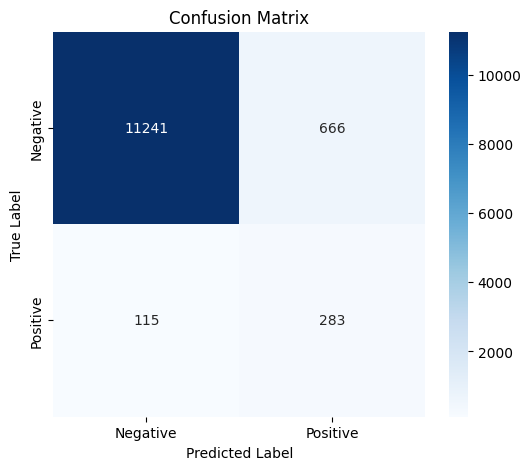

True Positives (TP): 283
False Positives (FP): 666
True Negatives (TN): 11241
False Negatives (FN): 115


In [17]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



net.load_state_dict(torch.load('/content/best.pth'))
# Perform inference on the new data
net.eval()
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = net(inference_inputs)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
total_predictions=len(predictions)
count_ones = (predictions == 1).sum()
print(f"Number of 1s in predictions: {count_ones}")
print(f"Number of 0s in predictions: {total_predictions - count_ones}")
print(f"Total number of predictions: {total_predictions}")


accuracy = accuracy_score(labels,predictions)
precision = precision_score(labels,predictions)
recall = recall_score(labels, predictions)
f1_val = f1_score(labels, predictions)
auc_roc = roc_auc_score(labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))



# Compute Confusion Matrix
cm = confusion_matrix(labels,predictions)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")



